Copyright (c) 2020 Joel BASSA
<br/>
**Objectif:** ce projet a pour objectif de mettre en oeuvre un modèle d'apprentissage supervisé pour la prédiction des retards à l'arrivée des vols en direction de l'aéroport de **BOS** .

■ Prédire la direction (hausse/baisse)
de l’indice boursier S&P/TSX

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## 0 - Import des bibliothèques

In [2]:
from datetime import datetime
from tqdm import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, f1_score, confusion_matrix, roc_auc_score, roc_curve

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from helpers import plot_confusion_matrix

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5, })
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1 - Chargement et exploration sommaire des données

<strong>Lecture du fichier `TSX.csv`<strong/>

In [4]:
TSX = pd.read_csv('TSX.csv', index_col=0)

<strong>Affichage des dix premières lignes de la trame de données TSX</strong>

In [5]:
TSX.head(10)

,tsx,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27
0,0.0,0.004025,-0.002421,-0.003893,0.000882,-0.002927,-0.003078,0.000344,-0.003201,-0.005980,...,-0.019445,0.001079,-0.004475,-0.000681,-0.004152,-0.000917,-0.005947,-0.002636,-0.004945,-0.000807
1,0.0,-0.000174,0.004025,-0.002421,-0.005980,0.000882,-0.002927,-0.005903,0.000344,-0.003201,...,-0.001731,-0.002165,0.001079,-0.004475,-0.001888,-0.004152,-0.000917,-0.015685,-0.002636,-0.004945
2,0.0,-0.001359,-0.000174,0.004025,0.006746,-0.005980,0.000882,0.006281,-0.005903,0.000344,...,-0.002733,-0.001671,-0.002165,0.001079,0.002962,-0.001888,-0.004152,-0.006410,-0.015685,-0.002636
3,1.0,-0.003332,-0.001359,-0.000174,0.001295,0.006746,-0.005980,-0.000583,0.006281,-0.005903,...,-0.018851,0.005646,-0.001671,-0.002165,0.014043,0.002962,-0.001888,0.001403,-0.006410,-0.015685
4,0.0,0.000427,-0.003332,-0.001359,0.004879,0.001295,0.006746,0.004575,-0.000583,0.006281,...,0.009911,0.002728,0.005646,-0.001671,0.000115,0.014043,0.002962,0.003371,0.001403,-0.006410
5,0.0,-0.013023,0.000427,-0.003332,-0.000477,0.004879,0.001295,-0.003133,0.004575,-0.000583,...,-0.008557,-0.009446,0.002728,0.005646,-0.005087,0.000115,0.014043,-0.012790,0.003371,0.001403
6,0.0,-0.008975,-0.013023,0.000427,-0.008046,-0.000477,0.004879,-0.008859,-0.003133,0.004575,...,0.005671,-0.009994,-0.009446,0.002728,-0.009023,-0.005087,0.000115,0.001433,-0.012790,0.003371
7,0.0,-0.000562,-0.008975,-0.013023,0.002009,-0.008046,-0.000477,-0.000647,-0.008859,-0.003133,...,-0.014532,-0.009976,-0.009994,-0.009446,-0.015853,-0.009023,-0.005087,0.001208,0.001433,-0.012790
8,1.0,-0.015120,-0.000562,-0.008975,-0.016301,0.002009,-0.008046,-0.015123,-0.000647,-0.008859,...,-0.001415,0.001458,-0.009976,-0.009994,-0.002048,-0.015853,-0.009023,-0.012300,0.001208,0.001433
9,0.0,0.008904,-0.015120,-0.000562,0.008539,-0.016301,0.002009,0.007125,-0.015123,-0.000647,...,-0.006437,-0.000420,0.001458,-0.009976,-0.007153,-0.002048,-0.015853,-0.008880,-0.012300,0.001208


<strong>Affichage du nombre d'observations</strong>

In [6]:
TSX.shape

(1061, 28)

#### Affichage du nom des variables indicatrices

In [7]:
TSX.columns

Index(['tsx', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27'],
      dtype='object')

Nous remarquons que les colonnes sont osfusquées

#### Affichage du type des variables indicatrices

In [8]:
TSX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 0 to 1060
Data columns (total 28 columns):
tsx    1061 non-null float64
x1     1061 non-null float64
x2     1061 non-null float64
x3     1061 non-null float64
x4     1061 non-null float64
x5     1061 non-null float64
x6     1061 non-null float64
x7     1061 non-null float64
x8     1061 non-null float64
x9     1061 non-null float64
x10    1061 non-null float64
x11    1061 non-null float64
x12    1061 non-null float64
x13    1061 non-null float64
x14    1061 non-null float64
x15    1061 non-null float64
x16    1061 non-null float64
x17    1061 non-null float64
x18    1061 non-null float64
x19    1061 non-null float64
x20    1061 non-null float64
x21    1061 non-null float64
x22    1061 non-null float64
x23    1061 non-null float64
x24    1061 non-null float64
x25    1061 non-null float64
x26    1061 non-null float64
x27    1061 non-null float64
dtypes: float64(28)
memory usage: 240.4 KB


#### Vérification de la proportion des classes positives (Hausse) et négatives (Baisse) 

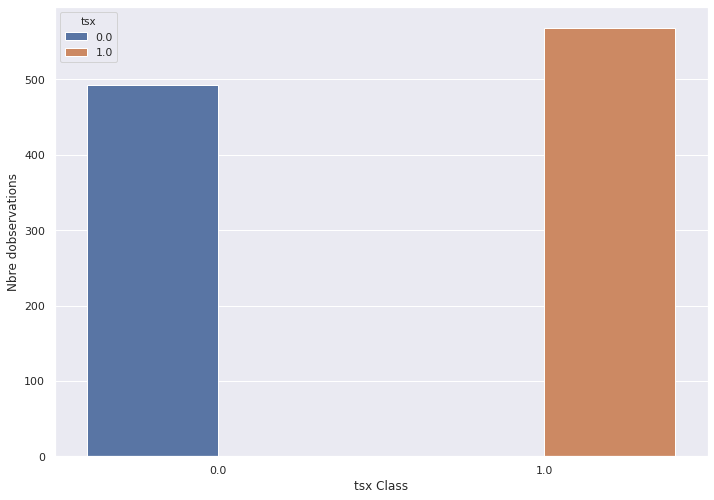

In [9]:
sns.countplot(x='tsx', hue='tsx', data=TSX)
plt.xlabel('tsx Class')
plt.ylabel('Nbre d''observations')
plt.show()

On remarque qu'il y'a un débalancement négligeable des classes. Aucune action n'est réquise pour l'instant.

#### conversion de la variable dépendante en entier

In [10]:
TSX['tsx'] = TSX['tsx'].astype(int)

#### Extraction des variables indépendentes et dépendante 

In [11]:
y = TSX[['tsx']].values.ravel() # Le ravel sert à éviter un warning tanant ...

TSX = TSX.drop(columns=['tsx'])
X = TSX.values


#### Sauvegarde du nombre d'observations

In [12]:
m = len(y)

## 2 - Standardisation des données

Etant donné que nos données contiennent plusieurs décimales, il est convient de les standardiser, afin de profiter de profiter de toute la puissance de certains de nos algorithmes.
Notre choix s'est basé sur le robustScaler afin de mieux gerer les valeurs abberrantes.

In [13]:
scaler = RobustScaler().fit(X)
X_scale = scaler.transform(X)

## 3 -Mélange des données et séparation en jeu d’entraînement et de test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.30, random_state=2020)

In [15]:
X_train.shape

(742, 27)

In [16]:
X_test.shape

(319, 27)

Pour la suite des choses, nous entrainerons plusieurs algorithmes sur nos données. Nos modèles de classification obtenus seront souples, c'est à dire la possibilité de prédire des valeurs continues dans l'intervalle [0,1]. Cela apporte une certaine flexibilité à notre solution.Dans tous les cas il existe des techniques permettant la conversion vers des prédictions rigides.

Aussi, la métrique utilisée sera `l'entropie croisée (Log-loss)`. Elle permet de mieux comparer les scores de prédictions qui contiennent plusieurs décimales.

## 4 - Modèle de référence

In [17]:
baseline_clf = DummyClassifier(strategy='most_frequent') 
baseline_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [18]:
dummy_score = log_loss(y_train, baseline_clf.predict_proba(X_train)[:,1])

In [19]:
history = {}
history['Baseline'] = dummy_score
history

{'Baseline': 16.106055651415016}

Notre essayerons de faire beaucoup mieux que le modèle baseline. Let's go!

## 5 - Régression logistique

[class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [20]:
# Grille de recherche
parameters = {'C':[0.01, 0.1, 1],
              'l1_ratio':[0, 0.1, 0.2, 0.3, 0.4],
              'penalty': ['none', 'elasticnet']}

# Modèle
clf_logreg = LogisticRegression(max_iter=10000,
                                  solver='saga',
                                  random_state=2020)

# Recherche sur grille avec validation croisée
clf_logreg_grid = GridSearchCV(clf_logreg, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [21]:
clf_logreg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=2020, solver='saga',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4],
                         'penalty': ['none', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [22]:
print(f'Meilleurs paramètres: {clf_logreg_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_logreg_grid.best_score_}')

Meilleurs paramètres: {'C': 0.1, 'l1_ratio': 0.4, 'penalty': 'elasticnet'}
Meilleur score (mean CV): -0.608381640229356


In [23]:
history['Logistic regression'] = -clf_logreg_grid.best_score_
history

{'Baseline': 16.106055651415016, 'Logistic regression': 0.608381640229356}

## 6 - K plus proches voisins

[class sklearn.neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [24]:
# Grille de recherche
parameters = {'n_neighbors':[75, 100, 125, 150],
              'p':[1, 2],
              'weights':['uniform', 'distance']}

# Modèle
clf_knn = KNeighborsClassifier()

# Recherche sur grille avec validation croisée
clf_knn_grid = GridSearchCV(clf_knn, parameters, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)

In [25]:
clf_knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [75, 100, 125, 150], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [26]:
print(f'Meilleurs paramètres: {clf_knn_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_knn_grid.best_score_}')

Meilleurs paramètres: {'n_neighbors': 75, 'p': 2, 'weights': 'distance'}
Meilleur score (mean CV): -0.6477582932030875


In [27]:
history['KNN'] = -clf_knn_grid.best_score_
history

{'Baseline': 16.106055651415016,
 'Logistic regression': 0.608381640229356,
 'KNN': 0.6477582932030875}

## 7 - Arbres de décision

[class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [28]:
# Distributions des hyperparamètres
distributions = dict(
    criterion=['gini', 'entropy'],
    ccp_alpha=loguniform(1e-4, 1e3),
    max_depth=randint(2, 128))

# Modèle
clf_tree = DecisionTreeClassifier(random_state=2020)

    
# Recherche aléatoire avec validation croisée
clf_tree_rnd = RandomizedSearchCV(clf_tree, distributions, n_iter=1000, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1, random_state=2020)

In [29]:
clf_tree_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1500 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 3500 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   58.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=2020,
          

In [30]:
print(f'Meilleurs paramètres: {clf_tree_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_tree_rnd.best_score_}')

Meilleurs paramètres: {'ccp_alpha': 0.00103461302917416, 'criterion': 'gini', 'max_depth': 2}
Meilleur score (mean CV): -0.6337946734365941


In [31]:
history['Decision Tree'] = -clf_tree_rnd.best_score_
history

{'Baseline': 16.106055651415016,
 'Logistic regression': 0.608381640229356,
 'KNN': 0.6477582932030875,
 'Decision Tree': 0.6337946734365941}

## 9 - Bagging (Arbres de décision)

[class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=None, random_state=None, verbose=0)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [32]:
clf_bag_dt = BaggingClassifier(base_estimator=clf_tree_rnd.best_estimator_, n_estimators=1000, verbose=1, n_jobs=-1, random_state=2020)

In [33]:
clf_bag_dt.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.00103461302917416,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=2,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random

In [34]:
# Score de validation croisée
cv_score_bag_dt = cross_val_score(clf_bag_dt, X_train, y_train, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


In [35]:
print(f'Score (mean CV): {cv_score_bag_dt}')

Score (mean CV): -0.6116900448893927


In [36]:
history['Bagging Decision Tree'] = -cv_score_bag_dt
history

{'Baseline': 16.106055651415016,
 'Logistic regression': 0.608381640229356,
 'KNN': 0.6477582932030875,
 'Decision Tree': 0.6337946734365941,
 'Bagging Decision Tree': 0.6116900448893927}

Ci-dessous, nos modèles classés par ordre de performance

In [37]:
[ print(key , " => " , value) for (key, value) in sorted(history.items() , key=lambda x: x[1]) ]

Logistic regression  =>  0.608381640229356
Bagging Decision Tree  =>  0.6116900448893927
Decision Tree  =>  0.6337946734365941
KNN  =>  0.6477582932030875
Baseline  =>  16.106055651415016


[None, None, None, None, None]

## 10 - Courbes d'apprentissage pour le meilleur modèle

La courbe d'apprentissage nous aidera à detecter certains problèmes comme le surapprentissage de nos meilleurs modèles. Pour ce faire , nous augmenterons graduellement nos données lors des entrainements et mesurerons le score de test et de validation.

### Regression logistique

In [38]:
lcurves = defaultdict(list)

for p in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    X_, y_ = resample(X_train, y_train, n_samples=p*m, stratify=y_train, random_state=2020)
    Xt, Xv, yt, yv = train_test_split(X_, y_, test_size=0.3, stratify=y_, random_state=2020)
    
    clf_logreg_grid.best_estimator_.fit(Xt, yt)
    
    lcurves['Train'].append(log_loss(yt,clf_logreg_grid.predict_proba(Xt)[:,1]))
    lcurves['Val'].append(log_loss(yv,clf_logreg_grid .predict_proba(Xv)[:,1]))

100%|██████████| 10/10 [00:00<00:00, 41.55it/s]


#### Affichage des courbes d'apprentissage

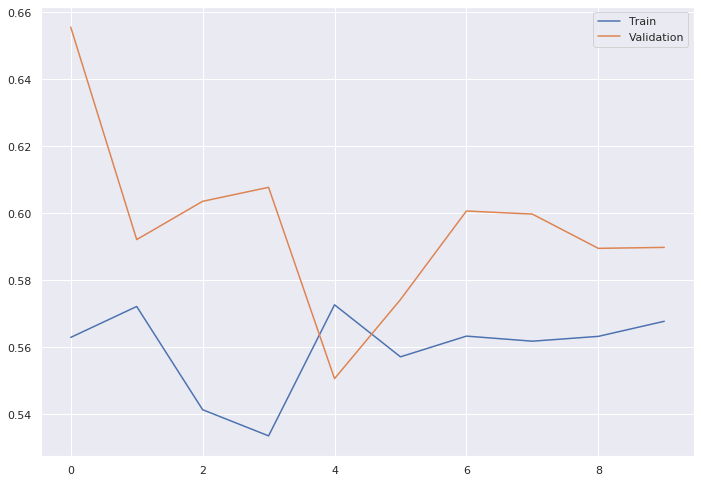

In [39]:
plt.plot(lcurves['Train'], label="Train")
plt.plot(lcurves['Val'], label="Validation")
plt.legend()

Le gap semble être un peu grand.Continuons avec notre deuxième meilleur modèle.

### Bagging decision tree

In [40]:
lcurves = defaultdict(list)

for p in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]):
    X_, y_ = resample(X_train, y_train, n_samples=p*m, stratify=y_train, random_state=2020)
    Xt, Xv, yt, yv = train_test_split(X_, y_, test_size=0.3, stratify=y_, random_state=2020)
    
    clf_bag_dt.fit(Xt, yt)
    
    lcurves['Train'].append(log_loss(yt,clf_bag_dt.predict_proba(Xt)[:,1]))
    lcurves['Val'].append(log_loss(yv,clf_bag_dt.predict_proba(Xv)[:,1]))

  0%|          | 0/10 [00:00<?, ?it/s][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
 10%|█         | 1/10 [00:02<00:24,  2.68s/it][Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.7s finished
[Parallel(n_jobs

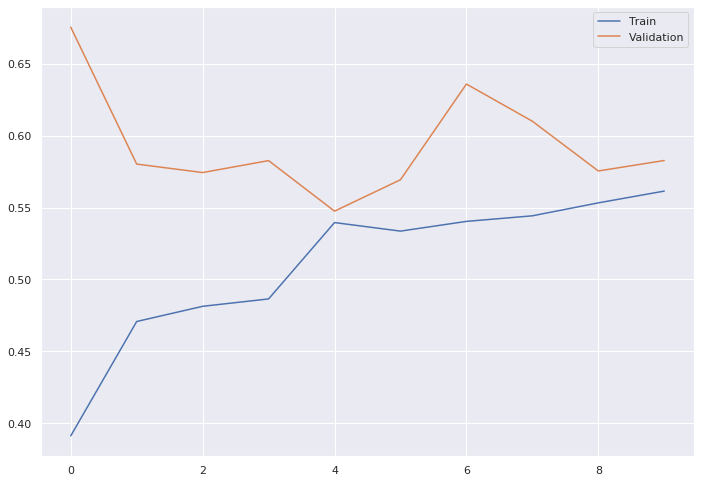

In [41]:
plt.plot(lcurves['Train'], label="Train")
plt.plot(lcurves['Val'], label="Validation")
plt.legend()

Ce modèle est beaucoup mieux. On remarque une convergence plus accentuée des deux courbes.

## 11 -  Réentraînement du meilleur modèle en prenant en compte les meilleurs hyperparamètres

In [42]:
clf_best= BaggingClassifier(base_estimator=clf_tree_rnd.best_estimator_, n_estimators=1000, verbose=1, n_jobs=-1, random_state=2020)

clf_best.fit(X, y)

cv_score = cross_val_score(clf_best, X_scale, y, cv=5, scoring="neg_log_loss", verbose=1, n_jobs=-1)
cv_score.mean()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


-0.608914719365245

## 12 - Prédictions sur le jeu de test

#### Calcul des prédictions sur le jeu de test

In [43]:
y_test_pred_proba_best = clf_best.predict_proba(X_test)[:,1]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


#### Calcul du log-loss

In [44]:
log_loss(y_test, y_test_pred_proba_best)

0.5892948214000612

Plusieurs autres métriques peuvent être calculées à titre indicatif, afin d'observer la performance de notre modèle sous d'autres angles.

#### Aire sous la courbe

In [45]:
print(f'AUC = {roc_auc_score(y_test, y_test_pred_proba_best)}')

AUC = 0.7732162632494859


#### Courbe ROC

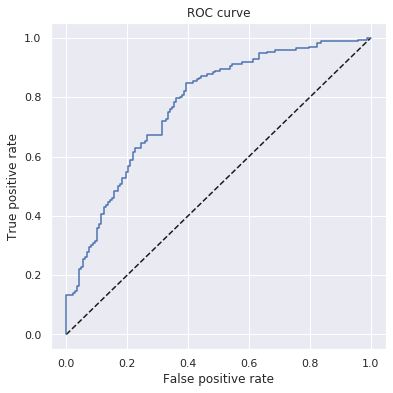

In [46]:
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_test_pred_proba_best)

fig = plt.figure(4, figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Meilleur modèle')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Recherche du meilleur seuil

In [47]:
selected_threshold = thresholds[np.argmax(-fpr_rf + tpr_rf)]
selected_threshold

0.2778741821125001

#### Score F1

In [48]:
f1_score(y_test, y_test_pred_proba_best > selected_threshold) # Attention, utiliser le seuil trouvé par validation croisée !

0.7733333333333334

#### Matrice de confusion

Confusion matrix, without normalization


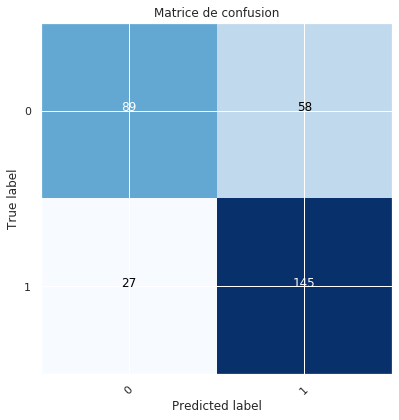

In [49]:
fig = plt.figure(3, figsize=(6, 6))

cnf_matrix = confusion_matrix(y_test, y_test_pred_proba_best > selected_threshold)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Matrice de confusion')

In [50]:
# Accuracy
(87+146)/(87+60+26+146)

0.7304075235109718

 **<center>FIN</center>**